# Cantenna at 2.4 GHz

This notebook will calculate the ideal properties of a "cantenna" (an open-ended waveguide antenna made from an aluminum can).

References:
- https://www.turnpoint.net/wireless/cantennahowto.html
- https://jacobsalmela.com/2013/09/07/wi-fi-cantenna-2-4ghz-how-to-make-a-long-range-wi-fi-antenna/
- http://web.archive.org/web/20080316034408/http://www.pelaginox.com/pc/pc-cancalc.html

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc

from rftools import CircularWaveguide as Waveguide
from rftools.util import pvalf

# https://github.com/garrettj403/SciencePlots
plt.style.use(['science', 'notebook'])

In [3]:
# center frequency of ISM band, in Hz
fc = 2.45 * sc.giga

In [4]:
# can diameter (sweep), in inches
diameters = np.linspace(2.6, 4, 201)

In [6]:
# calculate cutoff-frequency and minimum can height
min_height    = np.zeros_like(diameters)
f_cutoff_te11 = np.zeros_like(diameters)
f_cutoff_tm01 = np.zeros_like(diameters)
for i, d in np.ndenumerate(diameters):
    wg = Waveguide(d * sc.inch / 2, verbose=False)
    f_cutoff_te11[i] = wg.cutoff('TE11')
    f_cutoff_tm01[i] = wg.cutoff('TM01')
    min_height[i] = 0.75 * 2 * sc.pi / wg.beta(fc, mode='TE11')

## Min/max can diameters

Absolute minimum diameter required to launch the TE11 mode, and maximum diameter to avoid the TM01 mode:

In [7]:
d_min = np.interp(2.4, f_cutoff_te11[::-1] / 1e9, diameters[::-1])
d_max = np.interp(2.5, f_cutoff_tm01[::-1] / 1e9, diameters[::-1])
pvalf("Min diameter", d_min, "in")
pvalf("Max diameter", d_max, "in")

	Min diameter    =   2.882		[in]          
	Max diameter    =   3.614		[in]          


Ideally, the can should be about 3.5" in diameter. This allows the TE10 mode to propagate, but avoid the higher-order modes.

## Plot cutoff-frequency

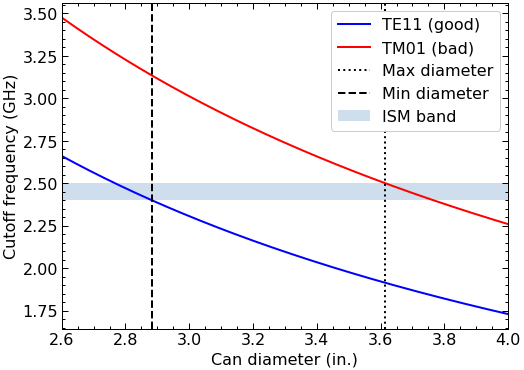

In [18]:
_, ax = plt.subplots()
ax.plot(diameters, f_cutoff_te11 / 1e9, 'b', label='TE11 (good)')
ax.plot(diameters, f_cutoff_tm01 / 1e9, 'r', label='TM01 (bad)')
ax.axhspan(2.4, 2.5, alpha=0.2, label='ISM band')
ax.axvline(d_max, c='k', ls=':', label='Max diameter')
ax.axvline(d_min, c='k', ls='--', label='Min diameter')
ax.set(xlabel="Can diameter (in.)", ylabel="Cutoff frequency (GHz)", xlim=[2.6, 4])
ax.legend(frameon=True, framealpha=1);

## Plot minimum can height

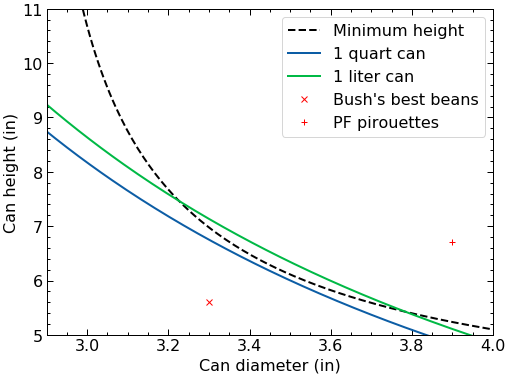

In [19]:
_, ax = plt.subplots()
ax.plot(diameters, min_height / sc.inch, 'k--', label='Minimum height')
qt_height = (32 * sc.fluid_ounce) / ((diameters * sc.inch / 2)**2 * sc.pi) / sc.inch
ax.plot(diameters, qt_height, label='1 quart can')
l_height = (1 * sc.liter) / ((diameters * sc.inch / 2)**2 * sc.pi) / sc.inch
ax.plot(diameters, l_height, label='1 liter can')
ax.plot(3.3, 5.6, 'rx', label="Bush's best beans")
ax.plot(3.9, 6.7, 'r+', label="PF pirouettes")
ax.set(xlabel="Can diameter (in)", ylabel="Can height (in)", xlim=[2.9, 4.0], ylim=[5, 11])
ax.legend(frameon=True);

For an ideal 3.5 inch diameter can, we want a volume of...

In [17]:
height = np.interp(3.5, diameters, min_height / sc.inch)
vol = (3.5 * sc.inch / 2)**2 * sc.pi * (height * sc.inch) / sc.fluid_ounce
pvalf("Volume", vol,    "fl oz")
pvalf("Height", height, "in")

	Height          =   6.113		[in]          
	Volume          =  32.587		[fl oz]       


...which is approximately 1 quart. Therefore, the ideal can would be a 1 qt can with a diameter of 3.5".

## Analyze Pirouette can

Unforunately, it is very difficult to find cans with a diameter of 3.5" and a volume of 1 quart. The best I could do was a can of Pepperidge Farm Pirouettes, which has a diameter of 3.9". 

In [33]:
diameter = 3.9 * sc.inch

wg = Waveguide(diameter / 2, verbose=False)
f_cutoff_te11 = wg.cutoff('TE11')
f_cutoff_tm01 = wg.cutoff('TM01')
guided_wavelength = 2 * sc.pi / wg.beta(fc, mode='TE11')
freespace_wavelength = sc.c / fc

print("Pepperidge Farm Pirouettes cans:\n")
pvalf("TE11 cutoff",   f_cutoff_te11 / sc.giga,            "GHz")
pvalf("TM01 cutoff",   f_cutoff_tm01 / sc.giga,            "GHz")
print("")
print("-> Guided wavelength")
pvalf("Wavelength", guided_wavelength / sc.inch,         "in")
pvalf("1/4 lambda", guided_wavelength / sc.inch / 4,     "in", "dist backshort -> probe")
pvalf("3/4 lambda", guided_wavelength / sc.inch * 3 / 4, "in", "minimum can height")
print("")
print("-> Freespace wavelength")
pvalf("Wavelength", freespace_wavelength / sc.inch,     "in")
pvalf("1/4 lambda", freespace_wavelength / sc.inch / 4, "in", "probe length")

Pepperidge Farm Pirouettes cans:

	TE11 cutoff     =   1.773		[GHz]         
	TM01 cutoff     =   2.317		[GHz]         

-> Guided wavelength
	Wavelength      =   6.983		[in]          
	1/4 lambda      =   1.746		[in]            # dist backshort -> probe
	3/4 lambda      =   5.237		[in]            # minimum can height

-> Freespace wavelength
	Wavelength      =   4.817		[in]          
	1/4 lambda      =   1.204		[in]            # probe length
